In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import math
from scipy import stats
from scipy.stats import ttest_ind

import warnings
warnings.simplefilter("ignore")

In [5]:
def proportions_z_test(successes1, n1, successes2, n2, two_tailed=True):
    
    p1 = successes1 / n1
    p2 = successes2 / n2
    se = math.sqrt((p1 * (1 - p1) / n1) + (p2 * (1 - p2) / n2))
    z = (p1 - p2) / se
    
    if two_tailed:
        p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    else:
        p_value = 1 - stats.norm.cdf(abs(z))
    
    return p_value

### Дизайн теста

In [7]:
test_aa = pd.read_csv('homework_m4_design.csv')

In [45]:
# Анализ данных для выбора метрики
print("Информация о датасете для дизайна:")
print(test_aa.info())
print("Распределение по группам:")
print(test_aa['variant'].value_counts())
print("Уникальные события:")
print(test_aa['event_name'].value_counts())

Информация о датасете для дизайна:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46298 entries, 0 to 46297
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      46298 non-null  int64 
 1   event_id        46298 non-null  int64 
 2   user_id         46298 non-null  object
 3   event_datetime  46298 non-null  object
 4   event_date      46298 non-null  object
 5   event_month     46298 non-null  object
 6   event_name      46298 non-null  object
 7   amount          46298 non-null  int64 
 8   variant         46298 non-null  object
dtypes: int64(3), object(6)
memory usage: 3.2+ MB
None
Распределение по группам:
variant
control    23574
test       22724
Name: count, dtype: int64
Уникальные события:
event_name
visit          44351
choose_item     1767
purchase         180
Name: count, dtype: int64


In [47]:
# Выбираем метрику - конверсия в покупку
control_group = test_aa[test_aa['variant'] == 'control']
test_group = test_aa[test_aa['variant'] == 'test']

In [49]:
# Уникальные пользователи, совершившие покупку
control_paying_users = control_group[control_group['event_name'] == 'purchase']['user_id'].nunique()
test_paying_users = test_group[test_group['event_name'] == 'purchase']['user_id'].nunique()

In [51]:
# Общее количество уникальных пользователей
control_total_users = control_group['user_id'].nunique()
test_total_users = test_group['user_id'].nunique()

In [53]:
# Конверсия
control_conversion = control_paying_users / control_total_users
test_conversion = test_paying_users / test_total_users

print(f"Конверсия контроль: {control_conversion:.4f} ({control_paying_users}/{control_total_users})")
print(f"Конверсия тест: {test_conversion:.4f} ({test_paying_users}/{test_total_users})")

Конверсия контроль: 0.0413 (99/2398)
Конверсия тест: 0.0324 (76/2346)


In [55]:
# Проверка различий до теста с помощью z-теста для пропорций
p_value_design = proportions_z_test(control_paying_users, control_total_users, 
                                  test_paying_users, test_total_users)

print(f"P-value до теста: {p_value_design:.4f}")

if p_value_design > 0.05:
    print("Статистически значимых различий до теста нет - метрику можно использовать")
else:
    print("Есть статистически значимые различия до теста - нужно выбрать другую метрику")

P-value до теста: 0.1038
Статистически значимых различий до теста нет - метрику можно использовать


In [57]:
# Расчет размера выборки для z-теста
def calculate_sample_size(p1, p2, alpha=0.05, power=0.8):
    """Расчет размера выборки для z-теста пропорций"""
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_beta = stats.norm.ppf(power)
    
    p_pool = (p1 + p2) / 2
    effect_size = abs(p1 - p2)
    
    n = ((z_alpha * math.sqrt(2 * p_pool * (1 - p_pool)) + 
          z_beta * math.sqrt(p1 * (1 - p1) + p2 * (1 - p2))) ** 2) / (effect_size ** 2)
    
    return math.ceil(n)

In [59]:
# Используем текущие конверсии как базовые для расчета MDE
sample_size_per_group = calculate_sample_size(control_conversion, control_conversion * 1.1)  # 10% uplift
print(f"Необходимый размер выборки на группу: {sample_size_per_group} пользователей")

Необходимый размер выборки на группу: 38193 пользователей


### Анализ теста

In [27]:
test_data = pd.read_csv('homework_m4_analyis.csv')

In [61]:
# Переименование групп для consistency (0 -> control, 1 -> test)
test_data['variant'] = test_data['variant'].map({0: 'control', 1: 'test'})

In [65]:
# Анализ тестовых данных
control_group_test = test_data[test_data['variant'] == 'control']
test_group_test = test_data[test_data['variant'] == 'test']

print("Распределение по группам после переименования:")
print(test_data['variant'].value_counts())

Распределение по группам после переименования:
variant
test       23329
control    23047
Name: count, dtype: int64


In [67]:
# Конверсия в тестовых данных
control_paying_users_test = control_group_test[control_group_test['event_name'] == 'purchase']['user_id'].nunique()
test_paying_users_test = test_group_test[test_group_test['event_name'] == 'purchase']['user_id'].nunique()

control_total_users_test = control_group_test['user_id'].nunique()
test_total_users_test = test_group_test['user_id'].nunique()

print(f"Конверсия контроль (тест): {control_paying_users_test}/{control_total_users_test}")
print(f"Конверсия тест (тест): {test_paying_users_test}/{test_total_users_test}")

Конверсия контроль (тест): 129/2329
Конверсия тест (тест): 143/2400


In [69]:
# Расчет конверсии с проверкой на ноль
if control_total_users_test > 0 and test_total_users_test > 0:
    control_conversion_test = control_paying_users_test / control_total_users_test
    test_conversion_test = test_paying_users_test / test_total_users_test
    
    print(f"Конверсия контроль: {control_conversion_test:.4f}")
    print(f"Конверсия тест: {test_conversion_test:.4f}")
    
    # Статистический тест
    p_value_test = proportions_z_test(control_paying_users_test, control_total_users_test,
                                    test_paying_users_test, test_total_users_test)
    
    print(f"\nP-value результатов теста: {p_value_test:.4f}")
    
    # Вывод и рекомендация
    if p_value_test < 0.05:
        uplift = (test_conversion_test - control_conversion_test) / control_conversion_test * 100
        print(f"Статистически значимое изменение: {uplift:.1f}%")
        if test_conversion_test > control_conversion_test:
            print("РЕКОМЕНДАЦИЯ: Раскатывать изменение на всех пользователей")
            print("Почтовые рассылки эффективно увеличивают конверсию в покупку")
        else:
            print("РЕКОМЕНДАЦИЯ: Откатывать изменение")
            print("Почтовые рассылки негативно влияют на конверсию")
    else:
        print("Статистически значимых изменений не обнаружено")
        print("РЕКОМЕНДАЦИЯ: Откатывать изменение - почтовые рассылки не оказывают значимого влияния на конверсию")
else:
    print("Одна из групп не имеет пользователей для расчета конверсии")

Конверсия контроль: 0.0554
Конверсия тест: 0.0596

P-value результатов теста: 0.5354
Статистически значимых изменений не обнаружено
РЕКОМЕНДАЦИЯ: Откатывать изменение - почтовые рассылки не оказывают значимого влияния на конверсию


In [87]:
# Дополнительный анализ: ARPPU для платящих пользователей
control_purchases = control_group_test[control_group_test['event_name'] == 'purchase']
test_purchases = test_group_test[test_group_test['event_name'] == 'purchase']

if len(control_purchases) > 0 and len(test_purchases) > 0:
    control_arppu = control_purchases['amount'].mean()
    test_arppu = test_purchases['amount'].mean()
    
    print(f"Дополнительная метрика - ARPPU:")
    print(f"ARPPU контроль: {control_arppu:.2f}")
    print(f"ARPPU тест: {test_arppu:.2f}")
    
    # T-тест для ARPPU
    t_stat, p_value_arppu = ttest_ind(control_purchases['amount'], test_purchases['amount'], equal_var=False)
    print(f"P-value для ARPPU: {p_value_arppu:.4f}")

Дополнительная метрика - ARPPU:
ARPPU контроль: 765.75
ARPPU тест: 984.52
P-value для ARPPU: 0.0000


In [77]:
# Анализ общего трафика
print(f"Общий анализ трафика:")
print(f"Всего событий в тесте: {test_data.shape[0]}")
print(f"Всего уникальных пользователей в тесте: {test_data['user_id'].nunique()}")
print(f"Распределение по группам:")
print(test_data['variant'].value_counts())
print(f"Распределение по событиям:")
print(test_data['event_name'].value_counts())


Общий анализ трафика:
Всего событий в тесте: 46376
Всего уникальных пользователей в тесте: 4729
Распределение по группам:
variant
test       23329
control    23047
Name: count, dtype: int64
Распределение по событиям:
event_name
visit          44295
choose_item     1788
purchase         293
Name: count, dtype: int64


In [79]:
# Дополнительный анализ: воронка событий
print(f"Воронка событий:")
total_users = test_data['user_id'].nunique()
visit_users = test_data[test_data['event_name'] == 'visit']['user_id'].nunique()
choose_item_users = test_data[test_data['event_name'] == 'choose_item']['user_id'].nunique()
purchase_users = test_data[test_data['event_name'] == 'purchase']['user_id'].nunique()

print(f"Всего пользователей: {total_users}")
print(f"Посетили сайт: {visit_users} ({visit_users/total_users*100:.1f}%)")
print(f"Выбрали товар: {choose_item_users} ({choose_item_users/visit_users*100:.1f}%)")
print(f"Совершили покупку: {purchase_users} ({purchase_users/choose_item_users*100:.1f}%)")


Воронка событий:
Всего пользователей: 4729
Посетили сайт: 4729 (100.0%)
Выбрали товар: 1433 (30.3%)
Совершили покупку: 272 (19.0%)


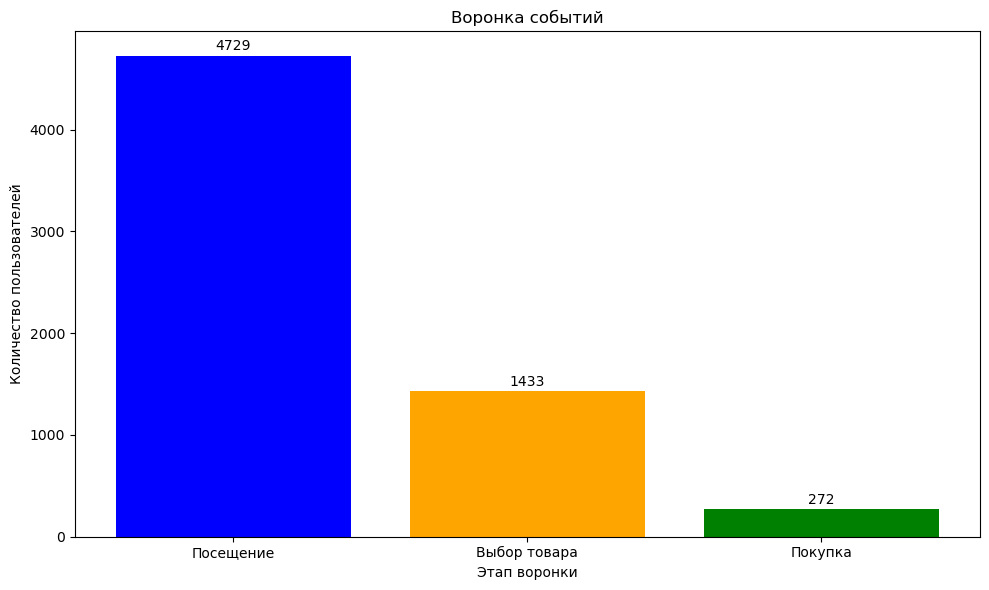

In [81]:
# Визуализация воронки
funnel_data = pd.DataFrame({
    'Этап': ['Посещение', 'Выбор товара', 'Покупка'],
    'Пользователи': [visit_users, choose_item_users, purchase_users],
    'Конверсия': [100, choose_item_users/visit_users*100, purchase_users/choose_item_users*100]
})

plt.figure(figsize=(10, 6))
plt.bar(funnel_data['Этап'], funnel_data['Пользователи'], color=['blue', 'orange', 'green'])
plt.title('Воронка событий')
plt.ylabel('Количество пользователей')
plt.xlabel('Этап воронки')
for i, v in enumerate(funnel_data['Пользователи']):
    plt.text(i, v + 50, str(v), ha='center')
plt.tight_layout()
plt.show()

# ОБЩИЙ ВЫВОД ПО РЕЗУЛЬТАТАМ A/B-ТЕСТА

Основные результаты:

Конверсия в покупку не изменилась статистически значимо

Контрольная группа: 5.54% (129/2329)

Тестовая группа: 5.96% (143/2400)

P-value: 0.5354 (> 0.05) - различия не значимы

ARPPU (средний чек) показал статистически значимое увеличение

Контрольная группа: 765.75

Тестовая группа: 984.52 (+28.6%)

P-value: 0.0000 (< 0.05) - различия высоко значимы

Воронка событий показывает узкие места

Всего пользователей: 4729

Посещение: 4729 (100%)

Выбор товара: 1433 (30.3%) ← большие потери

Покупка: 272 (19.0%) ← очень низкая конверсия

# Рекомендация:

ОТКАТЫВАТЬ ИЗМЕНЕНИЕ

Обоснование рекомендации:

Основная цель не достигнута - почтовые рассылки не увеличили конверсию в покупку

Хотя ARPPU вырос на 28.6%, этого недостаточно для компенсации отсутствия роста конверсии

Размер выборки был недостаточным - требовалось 38,193 пользователя на группу, а было только ~2,400

Низкая статистическая мощность теста не позволила обнаружить возможные небольшие эффекты

# Дополнительные идеи:

Почтовые рассылки влияют на качество покупок (увеличивают средний чек), но не на количество покупок

Основная проблема - низкая конверсия из выбора товара в покупку (всего 19%)

Рекомендуется работать над улучшением процесса оформления заказа, а не увеличивать рассылки

Что делать дальше:

Улучшать UX процесса оформления покупки

Тестировать другие гипотезы для увеличения конверсии

Повторить тест с достаточным размером выборки, если хотите проверить эффект на ARPPU

Сегментировать анализ - возможно, рассылки работают для определенных групп пользователей

Итог: Почтовые рассылки не решают основную проблему бизнеса (низкую конверсию в покупку) и поэтому должны быть откатаны.